In [1]:
import time
import numpy as np
import pandas as pd
from scipy import stats

from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.inspection import permutation_importance

import galsim #install with conda install -c conda_forge galsim

### Define functions

In [2]:
def log_mass_size(df):
    '''
    Converts to log10 non-zero size and mass entries (without distinguishing galaxy type)
    output: df with new columns of log mass, log size added to it

    '''
    #first let's remove all galaxy_mass=0 since you are going to at the end anyway
    df=df[df['mstar'] > 0]

#     #subhalo_flag = subhalos[‘SubhaloFlag’]
#     if type_of_galaxy == 'central':
#         df=df[df['subhalo_flag']==True]
#     elif type_of_galaxy == 'satellite':
#         df=df[df['subhalo_flag']==False]
#     else: 
#         print("type_of_galaxy must be set to central or satellite")

    #since we got rid of all zero mass we can just take the log10
    df['mstar_log']=np.log10(df['mstar'])
    df['half_radius_log']=np.log10(df['half_radius'])
    df['mhalo_log']=np.log10(df['mhalo'])
    df['Mhot_log']=np.log10(df['Mhot'])
    df['mbulge_log']=np.log10(df['mbulge'])

    return df

In [3]:
def log_SFR(df):
    '''
    Converts to log10 non-zero SFR entries (without distinguishing galaxy type)
    output: df with new columns of log SFR added to it

    '''
    #first let's remove all galaxy_mass=0 since you are going to at the end anyway
    df=df[df['sfr'] > 0]

    #since we got rid of all zero mass we can just take the log10
    df['sfr_log']=np.log10(df['sfr'])

    return df

In [4]:
# function to return the base 10 logarithm of non-zero values
def return_log(row, col):
    if(row[col]!= 0):
        return np.log10(row[col])
    else:
        return 0

In [5]:
# function to return the base 10 logarithm of non-zero values
def return_log_SFR(row, col):
    if(row[col]!= 0):
        return np.log10(row[col])
    else:
        return -2

In [6]:
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

### <font color='blue'> Define data frame

In [7]:
df=pd.read_hdf('./tng-sam_v2.h5') 


In [8]:
df

,mhalo,spin,Cnfw,Mhot,Macc,mstar,mHI,mH2,mbulge,r_bulge,r_disk,sfr,Zcold,Zstar,sat_type
0,8.945970e+08,0.03410,27.518700,1.150910e+08,0.0,1.918680e+04,1443460.0,350.895996,1.705140e+03,1.380600e-07,0.612071,2.099810e-07,6.425340e-06,1.847320e-08,0.0
1,1.815770e+09,0.04884,25.676800,9.966590e+07,0.0,5.311550e+05,1239300.0,574.640991,9.893530e+04,3.582890e-04,1.109940,3.485530e-07,5.455150e-05,2.259670e-06,0.0
2,4.880430e+09,0.07510,24.664200,1.409960e+07,0.0,1.461610e+06,51356600.0,120703.000000,2.745250e+05,3.465510e-03,1.129830,7.226970e-05,6.013470e-04,7.569950e-06,0.0
3,1.860050e+09,0.03953,19.896200,1.573440e+08,0.0,5.375590e+03,3270910.0,381.580017,2.401990e+03,5.426130e-08,0.905608,2.283380e-07,5.815860e-06,2.387450e-09,0.0
4,1.615000e+09,0.04429,28.457001,1.273490e+08,0.0,1.164560e+04,655190.0,66.861099,0.000000e+00,0.000000e+00,0.967984,4.000970e-08,6.864240e-06,1.009730e-08,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924830,8.857400e+08,0.01890,24.130699,9.038510e+07,0.0,1.155000e+03,274128.0,58.854900,4.672700e+01,1.623750e-10,0.357797,3.521890e-08,9.629620e-07,3.182000e-10,0.0
1924831,9.477410e+08,0.04871,18.530899,9.490910e+07,0.0,0.000000e+00,0.0,0.000000,0.000000e+00,0.000000e+00,0.891291,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1924832,1.617950e+09,0.03615,34.817600,1.473450e+08,0.0,6.519520e+03,589709.0,66.945503,1.819190e+03,1.039700e-07,0.790560,4.069460e-08,5.339940e-06,3.317030e-09,0.0
1924833,2.970180e+09,0.01930,15.964400,1.480060e+08,0.0,6.943700e+04,15834101.0,7420.919922,4.825620e+03,4.585310e-07,0.535545,4.442270e-06,3.334850e-05,9.543090e-08,0.0


#### mhalo = mass of halo, spin=halo spin, Mhot=hot gas mass of the halo, mstar=stellar mass, sfr=instantaneous sfr, Zcold=cold gas metallicity, Zstar=star metallicity

In [9]:
df.shape

(1924835, 15)

In [10]:
df['sat_type'].value_counts() # sat_type=0 corresponds to CENTRAL galaxies; 1,346,899 central galaxies

0.0    1346899
1.0     475176
2.0      91982
3.0      10122
4.0        611
5.0         45
Name: sat_type, dtype: int64

In [11]:
df['Macc'].value_counts()

0.0    1924835
Name: Macc, dtype: int64

In [12]:
df.columns.tolist()

['mhalo',
 'spin',
 'Cnfw',
 'Mhot',
 'Macc',
 'mstar',
 'mHI',
 'mH2',
 'mbulge',
 'r_bulge',
 'r_disk',
 'sfr',
 'Zcold',
 'Zstar',
 'sat_type']

### <font color='blue'> Filter the dataset

In [13]:
# remove all galaxies with stellar mass < 1e8
df_mass_filtered = df.loc[df.mstar>1e8,:]

In [14]:
df_mass_filtered.shape # 51,906 galaxies with stellar mass >1e8

(51906, 15)

In [15]:
df_mass_filtered['sat_type'].value_counts() # 35,390 central galaxies with stellar mass >1e8

0.0    35390
1.0    13686
2.0     2540
3.0      271
4.0       18
5.0        1
Name: sat_type, dtype: int64

In [16]:
df_central=df_mass_filtered.loc[df_mass_filtered.sat_type==0,:] # choose only CENTRALs

In [17]:
df_central

,mhalo,spin,Cnfw,Mhot,Macc,mstar,mHI,mH2,mbulge,r_bulge,r_disk,sfr,Zcold,Zstar,sat_type
53,4.502510e+09,0.03378,59.129101,9.503960e+09,0.0,1.050790e+08,2.710510e-11,0.0,72604704.0,0.503721,1.03908,0.000402,0.000008,0.004245,0.0
59,1.285310e+11,0.03407,21.878799,8.516240e+05,0.0,2.136860e+09,4.310100e+08,145516000.0,231256000.0,1.340100,1.44021,0.101277,0.206532,0.485612,0.0
82,1.171930e+11,0.01407,23.447201,5.588210e+05,0.0,1.583780e+09,3.059520e+08,46185400.0,240634992.0,1.801320,1.82321,0.028763,0.099900,0.308089,0.0
98,1.705850e+11,0.02229,17.701000,1.107320e+06,0.0,1.241640e+09,5.498750e+08,68248200.0,323452000.0,2.040110,2.30283,0.042378,0.160787,0.204719,0.0
104,8.294760e+10,0.01128,42.640499,1.935800e+05,0.0,1.432650e+09,1.699390e+08,24481200.0,490328000.0,1.414440,1.62481,0.015081,0.061155,0.310911,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1918905,5.192210e+10,0.03800,24.981800,3.574300e+04,0.0,1.312080e+08,2.422220e+08,7387440.0,7870290.5,0.861413,2.64082,0.004443,0.028542,0.007200,0.0
1918910,5.454680e+10,0.04917,16.239500,4.573560e+08,0.0,1.234320e+08,2.204080e+08,4975330.0,10646200.0,1.976380,3.47372,0.002984,0.036281,0.005770,0.0
1918945,5.175670e+10,0.03464,20.015400,1.392480e+08,0.0,1.227350e+08,4.174370e+08,75087504.0,20440200.0,0.553882,1.15671,0.051229,0.026656,0.006112,0.0
1918947,5.431060e+10,0.04613,20.577600,2.903790e+07,0.0,1.518140e+08,4.901590e+08,39315300.0,17960600.0,0.168341,1.62632,0.024660,0.041628,0.009348,0.0


In [18]:
df_central['sat_type'].value_counts()

0.0    35390
Name: sat_type, dtype: int64

In [19]:
np.log10(df_central['mstar'].max())

11.960914

In [20]:
np.log10(df_central['mhalo'].max())

14.686748

In [21]:
df_central[df_central['Zcold']<3].shape

(31688, 15)

In [22]:
35390-31688 # 3,702 galaxies with Zcold>3 

3702

In [23]:
df_central = df_central.loc[df_central.Zcold<3,:]

In [24]:
df_central.shape

(31688, 15)

In [25]:
31688-29781 # 1,907 galaxies with Zstar>3 remaining after filtering out galaxies with Zcold>3

1907

In [26]:
df_central = df_central.loc[df_central.Zstar<3,:] #remove galaxies with Zstar>3

In [27]:
df_central.shape

(29781, 15)

In [28]:
df_central = df_central.loc[df_central.mbulge>0.0,:] # remove all 5 entries where mbulge=0

In [29]:
df_central.shape

(29776, 15)

In [30]:
np.log10(df_central['mstar'].max()) # removing galaxies with Z>3 changes mstar(max) from 11.9 to 9.6, and mhalo(max) from ~14 to 12.6

9.960946

In [31]:
np.log10(df_central['mhalo'].max())

12.583929

In [32]:
df_central[df_central['Cnfw']<55].shape

(29570, 15)

In [33]:
df_central = df_central.loc[df_central.Cnfw<55,:] # remove all entries where Cnfw>55

In [34]:
df_central

,mhalo,spin,Cnfw,Mhot,Macc,mstar,mHI,mH2,mbulge,r_bulge,r_disk,sfr,Zcold,Zstar,sat_type
59,1.285310e+11,0.03407,21.878799,8.516240e+05,0.0,2.136860e+09,431010016.0,145516000.0,231256000.0,1.340100,1.44021,0.101277,0.206532,0.485612,0.0
82,1.171930e+11,0.01407,23.447201,5.588210e+05,0.0,1.583780e+09,305952000.0,46185400.0,240634992.0,1.801320,1.82321,0.028763,0.099900,0.308089,0.0
98,1.705850e+11,0.02229,17.701000,1.107320e+06,0.0,1.241640e+09,549875008.0,68248200.0,323452000.0,2.040110,2.30283,0.042378,0.160787,0.204719,0.0
104,8.294760e+10,0.01128,42.640499,1.935800e+05,0.0,1.432650e+09,169938992.0,24481200.0,490328000.0,1.414440,1.62481,0.015081,0.061155,0.310911,0.0
107,5.144180e+10,0.04394,33.175900,5.051540e+04,0.0,3.620070e+08,42364200.0,227020.0,100920000.0,0.362021,3.04418,0.003118,0.014877,0.030209,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1918905,5.192210e+10,0.03800,24.981800,3.574300e+04,0.0,1.312080e+08,242222000.0,7387440.0,7870290.5,0.861413,2.64082,0.004443,0.028542,0.007200,0.0
1918910,5.454680e+10,0.04917,16.239500,4.573560e+08,0.0,1.234320e+08,220408000.0,4975330.0,10646200.0,1.976380,3.47372,0.002984,0.036281,0.005770,0.0
1918945,5.175670e+10,0.03464,20.015400,1.392480e+08,0.0,1.227350e+08,417436992.0,75087504.0,20440200.0,0.553882,1.15671,0.051229,0.026656,0.006112,0.0
1918947,5.431060e+10,0.04613,20.577600,2.903790e+07,0.0,1.518140e+08,490159008.0,39315300.0,17960600.0,0.168341,1.62632,0.024660,0.041628,0.009348,0.0


In [35]:
np.log10(df_central['mstar'].max()) # removing all entries with Cnfw>55 doesn't change the max of mstar & mhalo

9.960946

In [36]:
np.log10(df_central['mhalo'].max())

12.583929

### <font color='blue'> Add half_radius by applying half_mass_radius function to each row

In [37]:
def half_mass_radius(mstar,mbulge,r_disk,r_bulge,tol=1.e-6,figure=False):
    '''calculate half mass radius for disk(n=1)+bulge(n=4) galaxy
    using bisection'''
    
    Md=mstar-mbulge # disk mass=stellar mass - bulge mass
    Rd=r_disk # disk radius
    Mb=mbulge # bulge mass
    Rb=r_bulge # bulge radius
    
    disk_fraction=Md/(Md+Mb)
    bulge_fraction=Mb/(Md+Mb)
    if bulge_fraction==0:
        disk=galsim.Sersic(scale_radius=Rd,n=1)  
        return disk.half_light_radius     
    if disk_fraction==0:
        return Rb
    disk=galsim.Sersic(scale_radius=Rd,n=1)
    bulge=galsim.Sersic(half_light_radius=Rb,n=4)
    #starting points for bisection
    a=bulge.half_light_radius
    b=disk.half_light_radius
    if b < a:
        a=disk.half_light_radius
        b=bulge.half_light_radius

    #bisection
    Ma=disk_fraction*disk.calculateIntegratedFlux(a)+bulge_fraction*bulge.calculateIntegratedFlux(a)
    Mb=disk_fraction*disk.calculateIntegratedFlux(b)+bulge_fraction*bulge.calculateIntegratedFlux(b)
    if np.sign(Ma-0.5)==np.sign(Mb-0.5):
        raise Exception("a and b do not bound a root")
    while(b-a > tol):
        m=0.5*(a+b)
        f=(disk_fraction*disk.calculateIntegratedFlux(m)+
            bulge_fraction*bulge.calculateIntegratedFlux(m))-0.5
        if np.sign(f)==1:
            b=m
        else:
            a=m
    half_radius=0.5*(a+b)
    if figure:
        half=np.array([0.45,0.55]) #used for half marks
        R=np.arange(0,3*b,0.02)
        N=len(R)
        yd=np.zeros(N)
        yb=np.zeros(N)
        for i in range(N):
            yd[i]=disk_fraction*disk.calculateIntegratedFlux(R[i])
            yb[i]=bulge_fraction*bulge.calculateIntegratedFlux(R[i])
        plt.plot(R,yd,color='b',label='disk')
        plt.plot(R,yb,color='r',label='bulge')
        plt.plot(R,yd+yb,color='k',label='total')
        plt.plot([bulge.half_light_radius,bulge.half_light_radius],bulge_fraction*half,color='g')
        plt.plot([disk.half_light_radius,disk.half_light_radius],disk_fraction*half,color='g')
        plt.plot([half_radius,half_radius],half,color='g')
        plt.xlim([0,3*b])
        plt.ylim([0,1.0])
        plt.legend()
        plt.show()
    return half_radius

# if __name__=='__main__':
#     print(half_mass_radius(1.e10,3.5,0.e9,0.0,figure=True))

In [38]:
df_central.iloc[101,:]

mhalo       2.848440e+10
spin        3.295000e-02
Cnfw        2.261520e+01
Mhot        1.125360e+04
Macc        0.000000e+00
mstar       1.019750e+08
mHI         1.573830e+08
mH2         4.214800e+06
mbulge      2.560170e+07
r_bulge     2.657400e-03
r_disk      1.874540e+00
sfr         2.537740e-03
Zcold       1.247500e-02
Zstar       3.677930e-03
sat_type    0.000000e+00
Name: 7816, dtype: float32

In [39]:
#for i,row in df_central.iterrows():
df_central.loc[:,'half_radius'] = df_central.apply(lambda x: half_mass_radius(mstar=x['mstar'],mbulge=x['mbulge'],r_disk=x['r_disk'],r_bulge=x['r_bulge'],tol=1.e-6,figure=False), axis=1)

In [40]:
df_central['half_radius']

59         2.332662
82         2.922134
98         3.491710
104        2.360157
107        3.526875
             ...   
1918905    4.229993
1918910    5.548773
1918945    1.729907
1918947    2.406906
1918957    2.117134
Name: half_radius, Length: 29570, dtype: float64

In [41]:
# solution of the same problem using a for loop over the df rows
lst = []
for i,row in df_central.iterrows():
    result_iter = half_mass_radius(mstar=row['mstar'],mbulge=row['mbulge'],r_disk=row['r_disk'],r_bulge=row['r_bulge'],tol=1.e-6,figure=False)
    lst.append(result_iter)
    if i>100:
        break
               

In [42]:
lst

[2.3326619620962354, 2.922134029718011, 3.4917102387445444, 2.3601561747952067]

### <font color='blue'> Logarithmic scale of stellar mass, SFR, Mhalo

In [43]:
df_central.head(2)

,mhalo,spin,Cnfw,Mhot,Macc,mstar,mHI,mH2,mbulge,r_bulge,r_disk,sfr,Zcold,Zstar,sat_type,half_radius
59,1.285310e+11,0.03407,21.878799,851624.0,0.0,2.136860e+09,431010016.0,145516000.0,231256000.0,1.34010,1.44021,0.101277,0.206532,0.485612,0.0,2.332662
82,1.171930e+11,0.01407,23.447201,558821.0,0.0,1.583780e+09,305952000.0,46185400.0,240634992.0,1.80132,1.82321,0.028763,0.099900,0.308089,0.0,2.922134


In [44]:
df_central_log=log_mass_size(df_central)

In [45]:
df_central_log.head(2)

,mhalo,spin,Cnfw,Mhot,Macc,mstar,mHI,mH2,mbulge,r_bulge,...,sfr,Zcold,Zstar,sat_type,half_radius,mstar_log,half_radius_log,mhalo_log,Mhot_log,mbulge_log
59,1.285310e+11,0.03407,21.878799,851624.0,0.0,2.136860e+09,431010016.0,145516000.0,231256000.0,1.34010,...,0.101277,0.206532,0.485612,0.0,2.332662,9.329776,0.367852,11.109008,5.930248,8.364093
82,1.171930e+11,0.01407,23.447201,558821.0,0.0,1.583780e+09,305952000.0,46185400.0,240634992.0,1.80132,...,0.028763,0.099900,0.308089,0.0,2.922134,9.199695,0.465700,11.068902,5.747272,8.381359


In [46]:
df_central_log['mbulge_log'].max()

9.827953

In [47]:
df_central_log['mbulge_log'].min()

1.6382796

In [48]:
# add a column with the logarithmic value of SFR, setting any SFR=0 to a fixed value of -2
df_central_log['SFR_log'] = df_central_log.apply(lambda row: return_log_SFR(row, 'sfr'), axis=1)

In [49]:
df_central_log.head(2)

,mhalo,spin,Cnfw,Mhot,Macc,mstar,mHI,mH2,mbulge,r_bulge,...,Zcold,Zstar,sat_type,half_radius,mstar_log,half_radius_log,mhalo_log,Mhot_log,mbulge_log,SFR_log
59,1.285310e+11,0.03407,21.878799,851624.0,0.0,2.136860e+09,431010016.0,145516000.0,231256000.0,1.34010,...,0.206532,0.485612,0.0,2.332662,9.329776,0.367852,11.109008,5.930248,8.364093,-0.994489
82,1.171930e+11,0.01407,23.447201,558821.0,0.0,1.583780e+09,305952000.0,46185400.0,240634992.0,1.80132,...,0.099900,0.308089,0.0,2.922134,9.199695,0.465700,11.068902,5.747272,8.381359,-1.541164


### Gas fraction

In [50]:
df_central_log['neutral_H_mass']=(df_central_log['mHI']+df_central_log['mH2'])
df_central_log['baryon_mass']=df_central_log['neutral_H_mass']+df_central_log['mstar']
df_central_log['gas_fraction']=df_central_log['neutral_H_mass']/df_central_log['baryon_mass']

In [51]:
df_central_log.shape

(29570, 25)

In [52]:
np.count_nonzero(df_central_log['half_radius']) # this means that there are no size zero entries in TNG-SAM

29570

In [53]:
np.count_nonzero(df_central_log['mstar']) # this means that there are no mass zero entries in TNG-SAM

29570

In [54]:
np.count_nonzero(df_central_log['mhalo'])

29570

In [55]:
df_central_log.SFR_log.max()

0.701114478976595

In [56]:
df_central_log.SFR_log.min()

-5.732506770978273

In [57]:
df_central_log.gas_fraction.max()

0.9884608

In [58]:
df_central_log.gas_fraction.min()

0.0

### <font color='blue'> Remove values of half_radius>13

In [59]:
df_central_log[df_central_log['half_radius']>13] # 156 galaxies with half_radius>13

,mhalo,spin,Cnfw,Mhot,Macc,mstar,mHI,mH2,mbulge,r_bulge,...,half_radius,mstar_log,half_radius_log,mhalo_log,Mhot_log,mbulge_log,SFR_log,neutral_H_mass,baryon_mass,gas_fraction
8235,6.409800e+11,0.07514,6.65633,4.447430e+10,0.0,3.085440e+09,7.429190e+09,272848992.0,3.641560e+08,6.130370,...,15.423556,9.489317,1.188185,11.806845,10.648109,8.561288,-0.781690,7.702039e+09,1.078748e+10,0.713979
14432,2.087390e+11,0.08363,9.43794,5.571540e+09,0.0,8.727400e+08,7.974220e+08,19248900.0,1.296950e+08,0.562382,...,13.088236,8.940885,1.116881,11.319604,9.745975,8.112924,-1.937505,8.166709e+08,1.689411e+09,0.483406
14744,1.141040e+11,0.13769,9.38857,1.000720e+06,0.0,2.945990e+08,5.349420e+08,4704040.0,2.609760e+07,1.100500,...,14.527450,8.469232,1.162189,11.057301,6.000312,7.416601,-2.550347,5.396460e+08,8.342450e+08,0.646868
31749,1.987010e+11,0.14277,4.91520,1.049310e+10,0.0,1.758870e+08,1.957810e+09,1523270.0,2.151860e+07,0.155275,...,20.750002,8.245234,1.317018,11.298200,10.020904,7.332814,-3.040209,1.959333e+09,2.135220e+09,0.917626
50766,6.775910e+11,0.06462,5.50582,4.551530e+10,0.0,4.067950e+09,6.742400e+09,332956000.0,1.110300e+09,8.200060,...,13.751855,9.609376,1.138361,11.830968,10.658157,9.045441,-0.693556,7.075356e+09,1.114331e+10,0.634942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1894083,1.176610e+11,0.13531,9.48836,4.331180e+08,0.0,1.998040e+08,3.164400e+09,6535430.0,1.121590e+07,1.436210,...,13.528393,8.300604,1.131246,11.070633,8.636606,7.049834,-2.407529,3.170936e+09,3.370739e+09,0.940724
1906318,2.558310e+11,0.08637,4.22338,1.289970e+10,0.0,2.852090e+08,4.633590e+09,41695200.0,3.084860e+07,0.056302,...,13.751259,8.455163,1.138342,11.407953,10.110579,7.489235,-1.601834,4.675286e+09,4.960495e+09,0.942504
1913043,3.250660e+11,0.06910,8.54036,8.566460e+09,0.0,2.268470e+09,1.162750e+09,40078800.0,2.674440e+08,2.031740,...,13.314768,9.355733,1.124334,11.511971,9.932801,8.427233,-1.618872,1.202829e+09,3.471299e+09,0.346507
1918446,2.426930e+11,0.08452,6.37991,1.684200e+10,0.0,2.046700e+08,1.582870e+09,2594350.0,1.196890e+07,2.129680,...,13.489721,8.311054,1.130003,11.385057,10.226394,7.078054,-2.808893,1.585464e+09,1.790134e+09,0.885668


In [60]:
df_central_log = df_central_log.loc[df_central_log.half_radius<13,:] # remove all entries where half_radius>13

In [61]:
df_central_log

,mhalo,spin,Cnfw,Mhot,Macc,mstar,mHI,mH2,mbulge,r_bulge,...,half_radius,mstar_log,half_radius_log,mhalo_log,Mhot_log,mbulge_log,SFR_log,neutral_H_mass,baryon_mass,gas_fraction
59,1.285310e+11,0.03407,21.878799,8.516240e+05,0.0,2.136860e+09,431010016.0,145516000.0,231256000.0,1.340100,...,2.332662,9.329776,0.367852,11.109008,5.930248,8.364093,-0.994489,576526016.0,2.713386e+09,0.212475
82,1.171930e+11,0.01407,23.447201,5.588210e+05,0.0,1.583780e+09,305952000.0,46185400.0,240634992.0,1.801320,...,2.922134,9.199695,0.465700,11.068902,5.747272,8.381359,-1.541164,352137408.0,1.935918e+09,0.181897
98,1.705850e+11,0.02229,17.701000,1.107320e+06,0.0,1.241640e+09,549875008.0,68248200.0,323452000.0,2.040110,...,3.491710,9.093996,0.543038,11.231941,6.044273,8.509809,-1.372860,618123200.0,1.859763e+09,0.332367
104,8.294760e+10,0.01128,42.640499,1.935800e+05,0.0,1.432650e+09,169938992.0,24481200.0,490328000.0,1.414440,...,2.360157,9.156140,0.372941,10.918804,5.286860,8.690487,-1.821570,194420192.0,1.627070e+09,0.119491
107,5.144180e+10,0.04394,33.175900,5.051540e+04,0.0,3.620070e+08,42364200.0,227020.0,100920000.0,0.362021,...,3.526875,8.558717,0.547390,10.711316,4.703424,8.003977,-2.506061,42591220.0,4.045982e+08,0.105268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1918905,5.192210e+10,0.03800,24.981800,3.574300e+04,0.0,1.312080e+08,242222000.0,7387440.0,7870290.5,0.861413,...,4.229993,8.117960,0.626340,10.715352,4.553191,6.895991,-2.352369,249609440.0,3.808174e+08,0.655457
1918910,5.454680e+10,0.04917,16.239500,4.573560e+08,0.0,1.234320e+08,220408000.0,4975330.0,10646200.0,1.976380,...,5.548773,8.091428,0.744197,10.736770,8.660254,7.027194,-2.525222,225383328.0,3.488153e+08,0.646139
1918945,5.175670e+10,0.03464,20.015400,1.392480e+08,0.0,1.227350e+08,417436992.0,75087504.0,20440200.0,0.553882,...,1.729907,8.088968,0.238023,10.713966,8.143789,7.310485,-1.290487,492524480.0,6.152595e+08,0.800515
1918947,5.431060e+10,0.04613,20.577600,2.903790e+07,0.0,1.518140e+08,490159008.0,39315300.0,17960600.0,0.168341,...,2.406906,8.181312,0.381459,10.734884,7.462965,7.254321,-1.608000,529474304.0,6.812883e+08,0.777166


In [62]:
df_central_log.half_radius.max() # removing galaxy sizes>13 do NOT change max stellar mass(which is 9.96) or mhalo;
# SFR_log minimum goes from -9 to -5 (those big size galaxies were not forming stars)

12.993273312607954

In [63]:
df_central_log.half_radius.min()

0.000314661129937268

In [64]:
df_central_log.mstar_log.max()

9.960946

In [65]:
df_central_log.mhalo_log.max()

12.583929

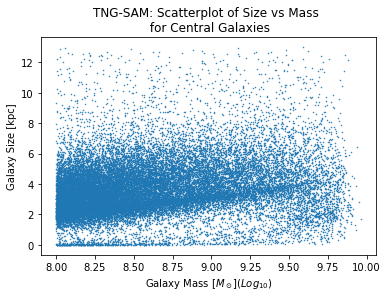

In [66]:
plt.plot(df_central_log['mstar_log'], df_central_log['half_radius'], '.', markersize=1)
plt.title('TNG-SAM: Scatterplot of Size vs Mass \n for Central Galaxies')
plt.xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
plt.ylabel('Galaxy Size [kpc]')
# plt.savefig("TNG-SAM_centrals_scatterplot_v3.jpeg", dpi=500)

plt.show()

## Correlations for all masses

In [67]:
df_central_log.head(2)

,mhalo,spin,Cnfw,Mhot,Macc,mstar,mHI,mH2,mbulge,r_bulge,...,half_radius,mstar_log,half_radius_log,mhalo_log,Mhot_log,mbulge_log,SFR_log,neutral_H_mass,baryon_mass,gas_fraction
59,1.285310e+11,0.03407,21.878799,851624.0,0.0,2.136860e+09,431010016.0,145516000.0,231256000.0,1.34010,...,2.332662,9.329776,0.367852,11.109008,5.930248,8.364093,-0.994489,576526016.0,2.713386e+09,0.212475
82,1.171930e+11,0.01407,23.447201,558821.0,0.0,1.583780e+09,305952000.0,46185400.0,240634992.0,1.80132,...,2.922134,9.199695,0.465700,11.068902,5.747272,8.381359,-1.541164,352137408.0,1.935918e+09,0.181897


In [68]:
# central_SIMBA = df_SIMBA_largebin.loc[df_SIMBA_largebin["galaxy_type"] == 'central',["galaxy_mass_log", "galaxy_size_log",'SFR', 'SFR_log', 'atomic_H_mass', 'molecular_H_mass','gas_fraction','BoverT', 'galaxy_angular_momentum',"galaxy_angular_momentum_log",'Mhalo_log', 'Shalo']]
# print(central_SIMBA.shape)
central_galaxies_mass=df_central_log["mstar_log"]
central_galaxies_size=df_central_log["half_radius"]
central_galaxies_size_log=df_central_log["half_radius_log"]
central_galaxies_SFR=df_central_log["sfr"]
central_galaxies_SFR_log=df_central_log["SFR_log"]
central_galaxies_atomic_H_mass=df_central_log["mHI"]
central_galaxies_molecular_H_mass=df_central_log["mH2"]
central_galaxies_gas_fraction=df_central_log["gas_fraction"]
central_galaxies_halo_angular_momentum=df_central_log["spin"]
central_galaxies_Mhalo=df_central_log["mhalo_log"]

In [69]:
mass_size_corr_central = round(stats.spearmanr(central_galaxies_mass, central_galaxies_size)[0], 2)
SFR_size_corr_central = round(stats.spearmanr(central_galaxies_SFR_log, central_galaxies_size )[0], 2)
SFR_mass_corr_central = round(stats.spearmanr(central_galaxies_SFR_log, central_galaxies_mass )[0], 2)
mom_size_corr_central = round(stats.spearmanr(central_galaxies_halo_angular_momentum, central_galaxies_size)[0], 2)


In [70]:
mass_size_corr_central

0.24

In [71]:
mom_size_corr_central

0.61

In [72]:
SFR_mass_corr_central

0.75

In [73]:
SFR_size_corr_central

0.2

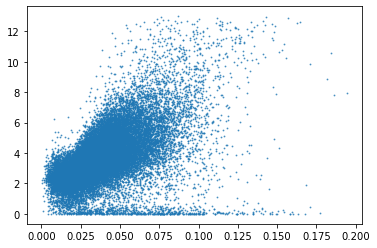

In [74]:
plt.scatter(central_galaxies_halo_angular_momentum, central_galaxies_size,  s=3, marker='.', alpha=0.7)

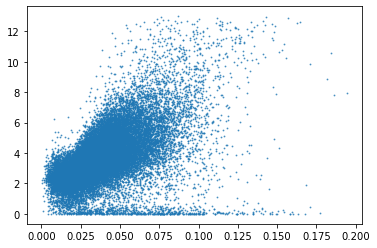

In [75]:
plt.scatter(df_central_log['spin'], df_central_log['half_radius'],  s=3, marker='.', alpha=0.7)

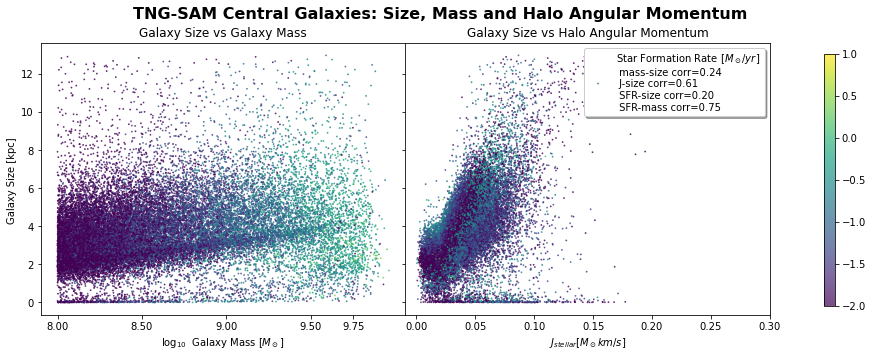

In [76]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(15,5))
fig.suptitle('TNG-SAM Central Galaxies: Size, Mass and Halo Angular Momentum  ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

# label = 'Star Formation Rate [$M_\odot / yr$] \n mass-size corr={} \n SFR-size corr={} \n SFR-mass corr={}'.format(10, mass_size_corr_central,SFR_size_corr_central,SFR_mass_corr_central )
# print(label)
im1 = ax1.scatter(df_central_log['mstar_log'], df_central_log['half_radius'], 
                  c = (df_central_log['SFR_log']),  s=3, marker='.', alpha=0.7 , vmin=-2, vmax=1.0)#, label=label)
# ax1.set_xlim([9.0, 11.5])
ax1.set_xticks([8.0, 8.5, 9.0, 9.5, 9.75])
# ax1.set_ylim([0.2,1.2])
ax1.set_title('Galaxy Size vs Galaxy Mass')
ax1.set_xlabel('$\log_{10} $  Galaxy Mass $[M_\odot] $')
ax1.set_ylabel('Galaxy Size [kpc] ')
# ax1.legend(loc='lower right', shadow=True)
# fig.colorbar(im1, ax=ax1)

label = 'Star Formation Rate [$M_\odot / yr$] \n mass-size corr=0.24 \n J-size corr=0.61 \n SFR-size corr=0.20 \n SFR-mass corr=0.75'
im2 = ax2.scatter(df_central_log['spin'], df_central_log['half_radius'], 
                  c = (df_central_log['SFR_log']),  s=3, marker='.', alpha=0.7,label= label, vmin=-2, vmax=1.0)
                  
# ax2.set_xlim([9,15])
ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
ax2.set_title('Galaxy Size vs Halo Angular Momentum')
ax2.set_xlabel('$ \, J_{stellar} [M_\odot km/s]$')
# ax2.set_ylabel('$\log_{10} \, \, Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='upper right' , shadow=True)
# fig.colorbar(im2, ax=ax2)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG-SAM_centrals_Mass_Size_AngMom_v4.jpeg", dpi=500)
plt.show()

In [77]:
df_central_log.columns.tolist()

['mhalo',
 'spin',
 'Cnfw',
 'Mhot',
 'Macc',
 'mstar',
 'mHI',
 'mH2',
 'mbulge',
 'r_bulge',
 'r_disk',
 'sfr',
 'Zcold',
 'Zstar',
 'sat_type',
 'half_radius',
 'mstar_log',
 'half_radius_log',
 'mhalo_log',
 'Mhot_log',
 'mbulge_log',
 'SFR_log',
 'neutral_H_mass',
 'baryon_mass',
 'gas_fraction']

In [78]:
df_central_log_pairplot = df_central_log.loc[:,["half_radius", "mstar_log", 
                                                'mhalo_log','spin', 'SFR_log', 'gas_fraction', 'Mhot_log', 
                                                "Cnfw", 'mbulge_log', 'Zcold', 'Zstar']]

In [79]:
df_central_log_pairplot.head(2)

,half_radius,mstar_log,mhalo_log,spin,SFR_log,gas_fraction,Mhot_log,Cnfw,mbulge_log,Zcold,Zstar
59,2.332662,9.329776,11.109008,0.03407,-0.994489,0.212475,5.930248,21.878799,8.364093,0.206532,0.485612
82,2.922134,9.199695,11.068902,0.01407,-1.541164,0.181897,5.747272,23.447201,8.381359,0.099900,0.308089


In [80]:
df_sample = df_central_log_pairplot.sample(n = 1000, random_state = 2022) #choose a subset of data to use for pairplot

In [81]:
df_sample.shape

(1000, 11)

### <font color='blue'> 1. a. Linear Regression Model - all features

In [82]:
df_central_log_pairplot.columns

Index(['half_radius', 'mstar_log', 'mhalo_log', 'spin', 'SFR_log',
       'gas_fraction', 'Mhot_log', 'Cnfw', 'mbulge_log', 'Zcold', 'Zstar'],
      dtype='object')

In [83]:
X = df_central_log_pairplot.loc[:, ['mstar_log', 'mhalo_log', 'spin', 'SFR_log', 'gas_fraction' , 'Mhot_log', 'Cnfw', 'mbulge_log','Zcold', 'Zstar']]


y = df_central_log_pairplot.loc[:,'half_radius']

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [85]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.6058041257890098

In [86]:
reg.score(X_test, y_test)

0.5998846050354851

In [87]:
# y_pred_reg=reg.predict(X_test)
y_pred_reg = cross_val_predict(reg, X_test, y_test, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [88]:
y_pred_reg

array([3.93293178, 3.65956799, 4.64158883, ..., 4.80339417, 2.22334514,
       4.34160282])

In [89]:
reg.feature_names_in_

array(['mstar_log', 'mhalo_log', 'spin', 'SFR_log', 'gas_fraction',
       'Mhot_log', 'Cnfw', 'mbulge_log', 'Zcold', 'Zstar'], dtype=object)

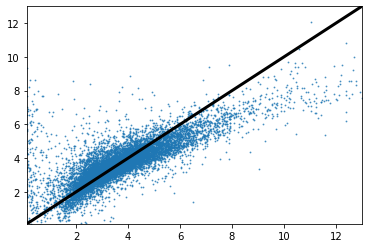

In [90]:
plt.scatter(y_test, y_pred_reg, s=3, marker='.', alpha=0.7)
plt.axis([0.1,13, 0.1,13])
# plt.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='-', color='k', lw=3, scalex=False, scaley=False)
plt.show()

In [91]:
slope, intercept = reg.coef_, reg.intercept_

In [92]:
slope, intercept

(array([ 5.32993269e+00,  7.78030332e-01,  4.18836251e+01, -1.83044035e+00,
         2.26301465e+00, -1.38250850e-03, -4.20672766e-02, -2.41654754e+00,
         5.31599660e-01, -8.08932834e-01]),
 -37.15866911640734)

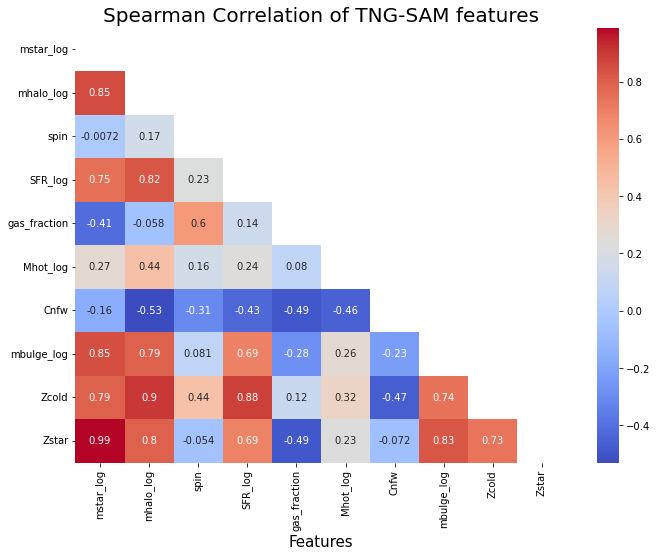

In [93]:
corr = X.corr('spearman')
plt.figure(figsize=(11,8))
matrix = np.triu(corr) # take upper correlation matrix
sns.heatmap(corr, cmap="coolwarm",annot=True, mask=matrix)
plt.title("Spearman Correlation of TNG-SAM features", fontsize = 20)
plt.xlabel("Features", fontsize = 15)
# plt.savefig('TNG-SAM_Spearman_correlation_matrix.jpeg', dpi=500)
plt.show()

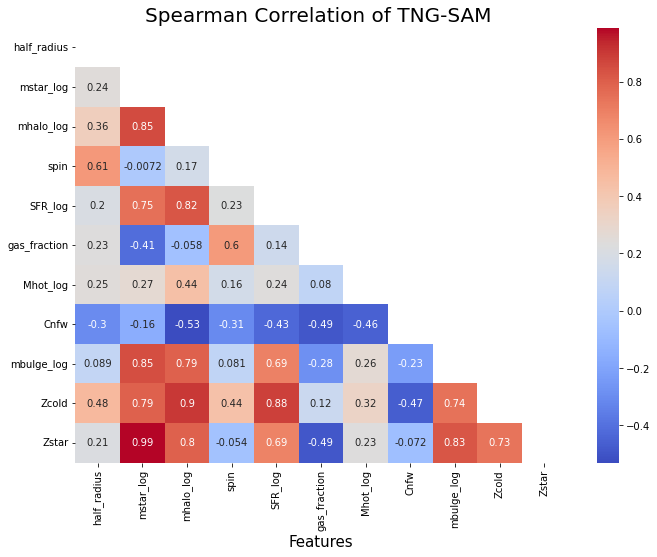

In [94]:
corr_df = df_central_log_pairplot.corr('spearman')
plt.figure(figsize=(11,8))
matrix = np.triu(corr_df) # take upper correlation matrix
sns.heatmap(corr_df, cmap="coolwarm",annot=True, mask=matrix)
plt.title("Spearman Correlation of TNG-SAM ", fontsize = 20)
plt.xlabel("Features", fontsize = 15)
# plt.savefig('TNG-SAM_Spearman_correlation_matrix.jpeg', dpi=500)
plt.show()

### <font color='blue'> 2. Random Forest Model

In [95]:
regr = RandomForestRegressor(max_depth=10, random_state=0)
# regr.fit(X_train, y_train)

In [96]:
from sklearn.model_selection import cross_val_score

In [97]:
cv_score = cross_val_score(regr, X, y, cv=5)

In [98]:
cv_score

array([0.81209063, 0.82961312, 0.83057556, 0.83126384, 0.82422493])

#### Hyperparameter tuning

In [99]:
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]
# number of features at every split
# max_features = ['auto', 'sqrt']


# create random grid
grid = {'bootstrap': [True],
               'max_depth': [5, 10, None],
#                'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
#                'min_samples_split': [2, 5, 10],
               'n_estimators': n_estimators}
# Random search of parameters
rfr_grid = GridSearchCV(estimator = regr, param_grid = grid, cv = 3, verbose=2, n_jobs = -1)
# Fit the model
rfr_grid.fit(X_train, y_train)
# print results
print(rfr_grid.best_params_)



Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 50}


In [100]:
# rfr_grid.cv_results_

In [101]:
#  y_pred = rfr_grid.best_estimator_.predict(X_test)
y_pred = cross_val_predict(rfr_grid.best_estimator_, X_test, y_test, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [102]:
y_pred

array([4.36019593, 4.55160379, 3.25198669, ..., 4.32874337, 1.94064752,
       2.75450281])

In [103]:
cv_score = cross_val_score(rfr_grid.best_estimator_, X, y, cv=5) # cv score in all data?

In [104]:
cv_score

array([0.87629093, 0.88344565, 0.88622265, 0.88635358, 0.89016003])

In [105]:
y_pred_cv = cross_val_predict(rfr_grid.best_estimator_, X_test, y_test, cv=3)


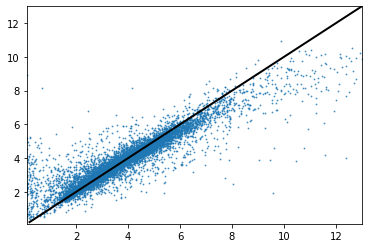

In [106]:
plt.scatter(y_test, y_pred_cv, s=3, marker='.', alpha=0.7)
plt.axis([0.1,13, 0.1,13])
plt.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
plt.show()

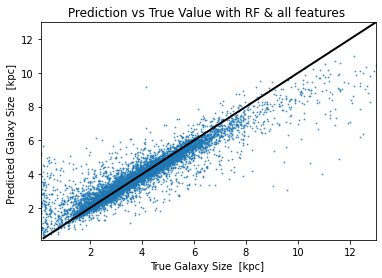

In [107]:
plt.scatter(y_test, y_pred, s=3, marker='.', alpha=0.7)
plt.axis([0.1,13, 0.1,13])
plt.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value with RF & all features ')
plt.xlabel('True Galaxy Size  [kpc] ')
plt.ylabel(' Predicted Galaxy Size  [kpc]  ')
# plt.savefig('Prediction_vs_True.jpeg', dpi=500)
# xpoints = ypoints = plt.xlim()
# plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.show()

In [108]:
rfr_grid.best_estimator_.score(X_test,y_test)

0.8714747213980494

In [109]:
rfr_grid.best_estimator_.score(X_train,y_train)

0.9812347499093789

### Feature Importances MDI

In [115]:

start_time = time.time()
importances = rfr_grid.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr_grid.best_estimator_.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.029 seconds


Elapsed time to compute the importances: 10.507 seconds


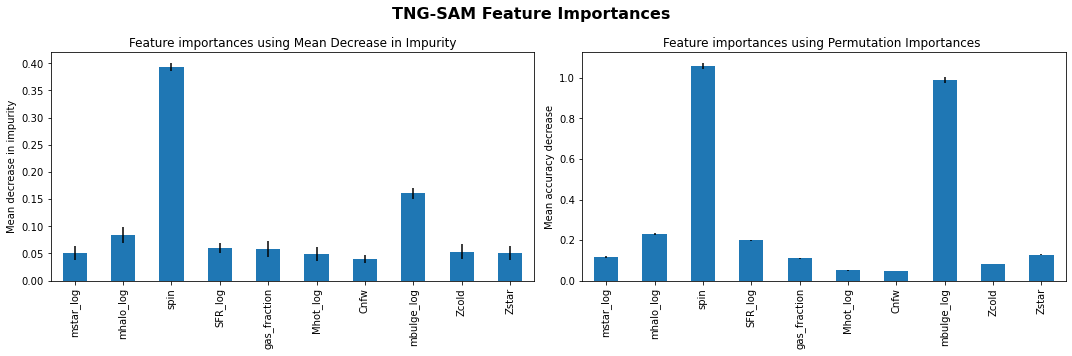

In [116]:

feature_names = X_test.columns

forest_importances = pd.Series(importances, index=feature_names)

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('TNG-SAM Feature Importances  ', fontsize=16, fontweight='bold')

forest_importances.plot.bar(yerr=std, ax=ax1)
ax1.set_title("Feature importances using Mean Decrease in Impurity")
ax1.set_ylabel("Mean decrease in impurity")
# plt.savefig("Feature_Importances_MDI.jpeg", dpi=500)



### Feature Importances Permutation


start_time = time.time()
result = permutation_importance(
    rfr_grid.best_estimator_, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

forest_importances.plot.bar(yerr=result.importances_std, ax=ax2)
ax2.set_title("Feature importances using Permutation Importances ")
ax2.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
# plt.savefig("Feature_Importances_Permutation.jpeg", dpi=500)

plt.show()

### <font color='blue'> 1. b. Linear Regression Model - only STELLAR mass_log 

In [117]:
X_train_stellar_mass = X_train.loc[:, ['mstar_log']]

In [118]:
X_train_stellar_mass.head(2)

,mstar_log
819253,8.295083
509747,9.268931


In [119]:
X_test_stellar_mass = X_test.loc[:, ['mstar_log']]

In [120]:
X_test_stellar_mass.shape

(9665, 1)

In [121]:
reg_stellar_mass = LinearRegression().fit(X_train_stellar_mass, y_train)
reg_stellar_mass.score(X_train_stellar_mass, y_train)

0.04085218827579995

In [122]:
reg_stellar_mass.score(X_test_stellar_mass, y_test)

0.04623465628293211

In [123]:
# y_pred_reg_stellar=reg_stellar_mass.predict(X_test_stellar_mass)
y_pred_reg_stellar = cross_val_predict(reg_stellar_mass, X_test_stellar_mass, y_test, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [124]:
y_test.shape , y_pred_reg_stellar.shape

((9665,), (9665,))

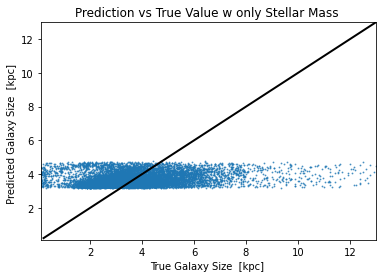

In [125]:
plt.scatter(y_test, y_pred_reg_stellar, s=3, marker='.', alpha=0.7)
plt.axis([0.1,13, 0.1,13])
plt.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value w only Stellar Mass ')
plt.xlabel('True Galaxy Size  [kpc] ')
plt.ylabel(' Predicted Galaxy Size  [kpc]  ')
plt.show()

In [126]:
slope_stellar_mass, intercept_stellar_mass = reg_stellar_mass.coef_, reg_stellar_mass.intercept_

In [127]:
slope_stellar_mass, intercept_stellar_mass

(array([0.75669277], dtype=float32), -2.8181481)

### <font color='blue'> 1. c. Linear Regression Model - only HALO mass_log 

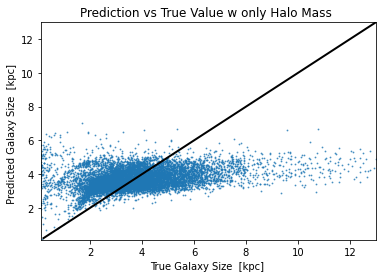

In [128]:
X_train_halo_mass = X_train.loc[:, ['mhalo_log']]

X_test_halo_mass = X_test.loc[:, ['mhalo_log']]

reg_halo_mass = LinearRegression().fit(X_train_halo_mass, y_train)
reg_halo_mass.score(X_train_halo_mass, y_train)

reg_halo_mass.score(X_test_halo_mass, y_test)

# y_pred_reg_halo=reg_halo_mass.predict(X_test_halo_mass)

y_pred_reg_halo = cross_val_predict(reg_halo_mass, X_test_halo_mass, y_test, cv = KFold(n_splits=5, shuffle=True, random_state=10))

plt.scatter(y_test, y_pred_reg_halo, s=3, marker='.', alpha=0.7)
plt.axis([0.1,13, 0.1,13])
plt.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value w only Halo Mass ')
plt.xlabel('True Galaxy Size  [kpc] ')
plt.ylabel(' Predicted Galaxy Size  [kpc]  ')
plt.show()

### <font color='blue'> 1. d. Linear Regression Model - only SPIN 

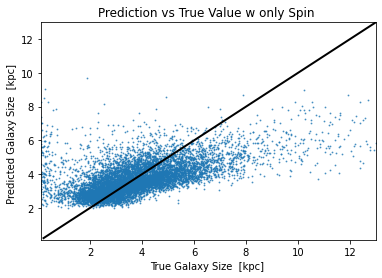

[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, n_estimators=30; total time=   1.2s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, n_estimators=10; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, n_estimators=30; total time=   2.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=30; total time=   2.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, n_estimators=30; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, n_estimators=10; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, n_estimators=50; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50; total time=   4.0s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, n_estimators=10; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_sampl

In [110]:
X_train_spin = X_train.loc[:, ['spin']]

X_test_spin = X_test.loc[:, ['spin']]

reg_spin = LinearRegression().fit(X_train_spin, y_train)
reg_spin.score(X_train_spin, y_train)

reg_spin.score(X_test_spin, y_test)

# y_pred_reg_halo=reg_halo_mass.predict(X_test_halo_mass)

y_pred_reg_spin = cross_val_predict(reg_spin, X_test_spin, y_test, cv = KFold(n_splits=5, shuffle=True, random_state=10))

plt.scatter(y_test, y_pred_reg_spin, s=3, marker='.', alpha=0.7)
plt.axis([0.1,13, 0.1,13])
plt.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value w only Spin ')
plt.xlabel('True Galaxy Size  [kpc] ')
plt.ylabel(' Predicted Galaxy Size  [kpc]  ')
plt.show()

In [ ]:
fig,[ax1, ax5, ax6 ]=plt.subplots(nrows=1,ncols=3,sharey=True, figsize=(15,5))
fig.suptitle('TNG-SAM Central Galaxies Size Prediction', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

label = 'Train score={} \n Test score={}'.format(round(reg_stellar_mass.score(X_train_stellar_mass, y_train), 2),round(reg_stellar_mass.score(X_test_stellar_mass, y_test), 2) )
# print(label)
im1 = ax1.scatter(y_test, y_pred_reg_stellar, s=3, marker='.', alpha=0.7, label=label)
# ax1.set_xlim([9.0, 11.5])
# ax1.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax1.set_ylim([0.2,1.2])
ax1.axis([0.1,1.3, 0.1,1.3])
ax1.plot([0.2, 1.2], [0.2, 1.2], color = 'black', linewidth = 2)
ax1.set_title('Linear Regression Model \n with only Stellar Mass')
ax1.set_xlabel('True $ log_{10} $ Galaxy Size  [kpc]')
ax1.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax1.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(reg.score(X_train, y_train), 2),round(reg.score(X_test, y_test), 2) )
im5 = ax5.scatter(y_test, y_pred_reg, s=3, marker='.', alpha=0.7, label=label)
# ax5.set_xlim([9.0, 11.5])
# ax5.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax5.set_ylim([0.2,1.2])
ax5.axis([0.1,1.3, 0.1,1.3])
ax5.plot([0.2, 1.2], [0.2, 1.2], color = 'black', linewidth = 2)
ax5.set_title('Linear Regression Model \n with all the features')
ax5.set_xlabel('True $ log_{10} $ Galaxy Size  [kpc]')
# ax5.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax5.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(rfr_grid.best_estimator_.score(X_train,y_train), 2),round(rfr_grid.best_estimator_.score(X_test,y_test), 2) )
im6 = ax6.scatter(y_test, y_pred, s=3, marker='.', alpha=0.7, label=label)
# ax6.set_xlim([9.0, 11.5])
# ax6.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax6.set_ylim([0.2,1.2])
ax6.axis([0.1,1.3, 0.1,1.3])
ax6.plot([0.2, 1.2], [0.2, 1.2], color = 'black', linewidth = 2)
ax6.set_title('Random Forest Regressor Model \n with all the features')
ax6.set_xlabel('True $ log_{10} $ Galaxy Size  [kpc]')
# ax6.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax6.legend(loc='lower right', shadow=True)
    
# grid = plt.GridSpec(3, 2)
# create_subtitle(fig, grid[0, ::], 'Linear Regression with only Stellar Mass as a feature')
# create_subtitle(fig, grid[1, ::], 'Linear Regression with only Halo Mass as a feature')
# create_subtitle(fig, grid[2, ::], 'Linear Regression vs Random Forest Regressor with all features')

# fig.subplots_adjust(hspace=0.0, wspace=0.0)
fig.tight_layout()
# plt.savefig("SIMBA_LR_vs_RF_size_prediction.jpeg", dpi=500)
plt.show()

### <font color='blue'> 1. e. Linear Regression Model - only BULGE mass log

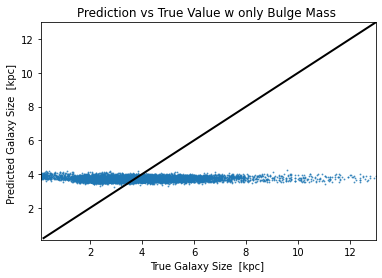

In [130]:
X_train_bulge_mass = X_train.loc[:, ['mbulge_log']]

X_test_bulge_mass = X_test.loc[:, ['mbulge_log']]

reg_bulge_mass = LinearRegression().fit(X_train_bulge_mass, y_train)
reg_bulge_mass.score(X_train_bulge_mass, y_train)

reg_bulge_mass.score(X_test_bulge_mass, y_test)

# y_pred_reg_halo=reg_halo_mass.predict(X_test_halo_mass)

y_pred_reg_bulge = cross_val_predict(reg_bulge_mass, X_test_bulge_mass, y_test, cv = KFold(n_splits=5, shuffle=True, random_state=10))

plt.scatter(y_test, y_pred_reg_bulge, s=3, marker='.', alpha=0.7)
plt.axis([0.1,13, 0.1,13])
plt.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value w only Bulge Mass ')
plt.xlabel('True Galaxy Size  [kpc] ')
plt.ylabel(' Predicted Galaxy Size  [kpc]  ')
plt.show()

### The figure containing all the models

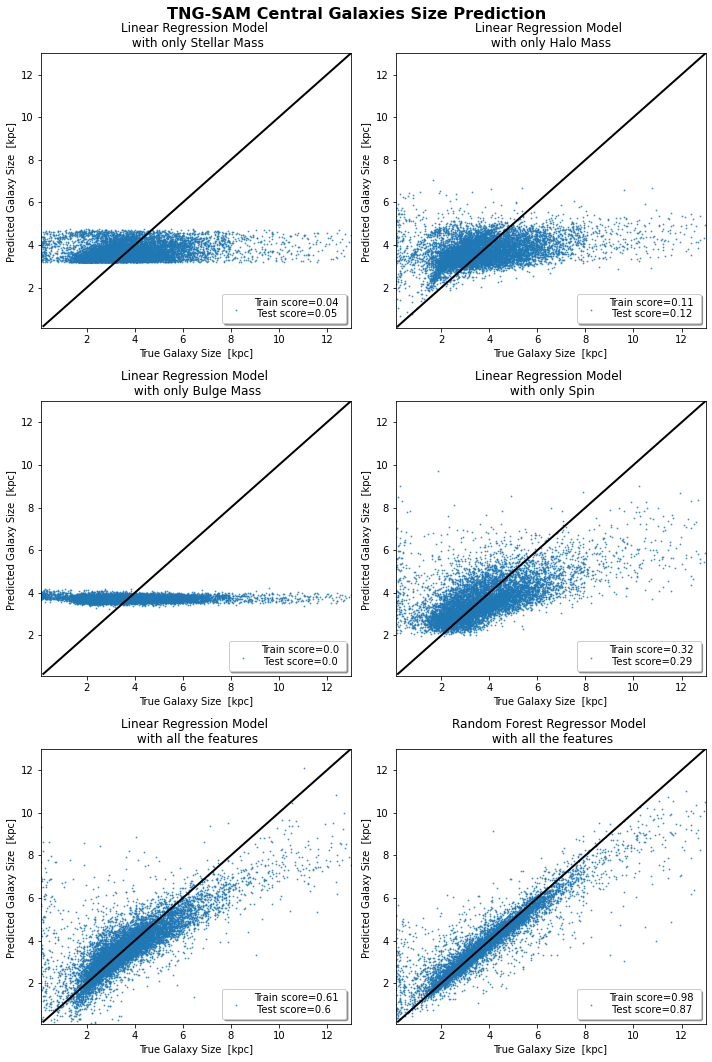

In [131]:
fig,[(ax1, ax2), (ax3, ax4), (ax5, ax6)]=plt.subplots(nrows=3,ncols=2,figsize=(10,15))
fig.suptitle('TNG-SAM Central Galaxies Size Prediction', fontsize=16, fontweight='bold')


label = 'Train score={} \n Test score={}'.format(round(reg_stellar_mass.score(X_train_stellar_mass, y_train), 2),round(reg_stellar_mass.score(X_test_stellar_mass, y_test), 2) )
# print(label)
im1 = ax1.scatter(y_test, y_pred_reg_stellar, s=3, marker='.', alpha=0.7, label=label)
# ax1.set_xlim([9.0, 11.5])
# ax1.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax1.set_ylim([0.2,1.2])
ax1.axis([0.1,13, 0.1,13])
ax1.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
ax1.set_title('Linear Regression Model \n with only Stellar Mass')
ax1.set_xlabel('True Galaxy Size  [kpc]')
ax1.set_ylabel('Predicted Galaxy Size  [kpc] ')
ax1.legend(loc='lower right', shadow=True)


label = 'Train score={} \n Test score={}'.format(round(reg_halo_mass.score(X_train_halo_mass, y_train), 2),round(reg_halo_mass.score(X_test_halo_mass, y_test), 2) )
im2 = ax2.scatter(y_test, y_pred_reg_halo, s=3, marker='.', alpha=0.7, label=label)
# ax2.set_xlim([9.0, 11.5])
# ax2.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax2.set_ylim([0.2,1.2])
ax2.axis([0.1,13, 0.1,13])
ax2.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
ax2.set_title('Linear Regression Model \n with only Halo Mass ')
ax2.set_xlabel('True Galaxy Size  [kpc]')
ax2.set_ylabel('Predicted Galaxy Size  [kpc] ')
ax2.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(reg_bulge_mass.score(X_train_bulge_mass, y_train), 2),round(reg_bulge_mass.score(X_test_bulge_mass, y_test), 2) )
im3 = ax3.scatter(y_test, y_pred_reg_bulge, s=3, marker='.', alpha=0.7, label=label)
# ax3.set_xlim([9.0, 11.5])
# ax3.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax3.set_ylim([0.2,1.2])
ax3.axis([0.1,13, 0.1,13])
ax3.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
ax3.set_title('Linear Regression Model \n with only Bulge Mass')
ax3.set_xlabel('True Galaxy Size  [kpc]')
ax3.set_ylabel('Predicted Galaxy Size  [kpc] ')
ax3.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(reg_spin.score(X_train_spin, y_train), 2),round(reg_spin.score(X_test_spin, y_test), 2) )
im4 = ax4.scatter(y_test, y_pred_reg_spin, s=3, marker='.', alpha=0.7, label=label)
# ax4.set_xlim([9.0, 11.5])
# ax4.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax4.set_ylim([0.2,1.2])
ax4.axis([0.1,13, 0.1,13])
ax4.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
ax4.set_title('Linear Regression Model \n with only Spin')
ax4.set_xlabel('True Galaxy Size  [kpc]')
ax4.set_ylabel('Predicted Galaxy Size  [kpc] ')
ax4.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(reg.score(X_train, y_train), 2),round(reg.score(X_test, y_test), 2) )
im5 = ax5.scatter(y_test, y_pred_reg, s=3, marker='.', alpha=0.7, label=label)
# ax5.set_xlim([9.0, 11.5])
# ax5.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax5.set_ylim([0.2,1.2])
ax5.axis([0.1,13, 0.1,13])
ax5.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
ax5.set_title('Linear Regression Model \n with all the features')
ax5.set_xlabel('True Galaxy Size  [kpc]')
ax5.set_ylabel('Predicted Galaxy Size  [kpc] ')
ax5.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(rfr_grid.best_estimator_.score(X_train,y_train), 2),round(rfr_grid.best_estimator_.score(X_test,y_test), 2) )
im6 = ax6.scatter(y_test, y_pred, s=3, marker='.', alpha=0.7, label=label)
# ax6.set_xlim([9.0, 11.5])
# ax6.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax6.set_ylim([0.2,1.2])
ax6.axis([0.1,13, 0.1,13])
ax6.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
ax6.set_title('Random Forest Regressor Model \n with all the features')
ax6.set_xlabel('True Galaxy Size  [kpc]')
ax6.set_ylabel('Predicted Galaxy Size  [kpc] ')
ax6.legend(loc='lower right', shadow=True)
    
# grid = plt.GridSpec(3, 2)
# create_subtitle(fig, grid[0, ::], 'Linear Regression with only Stellar Mass as a feature')
# create_subtitle(fig, grid[1, ::], 'Linear Regression with only Halo Mass as a feature')
# create_subtitle(fig, grid[2, ::], 'Linear Regression vs Random Forest Regressor with all features')

fig.subplots_adjust(top=0.95, hspace=0.5, wspace=0.5)
fig.tight_layout()
# plt.savefig("TNG-SAM_central_size_prediction.jpeg", dpi=500)
plt.show()

### <font color='blue'> 2.a. Random Forest Model eliminating features

In [132]:
X_el = df_central_log_pairplot.loc[:, ['mstar_log', 'mhalo_log', 'spin', 'SFR_log', 'gas_fraction' , 'Mhot_log', 'mbulge_log','Zcold', 'Zstar']]


y_el = df_central_log_pairplot.loc[:,'half_radius']

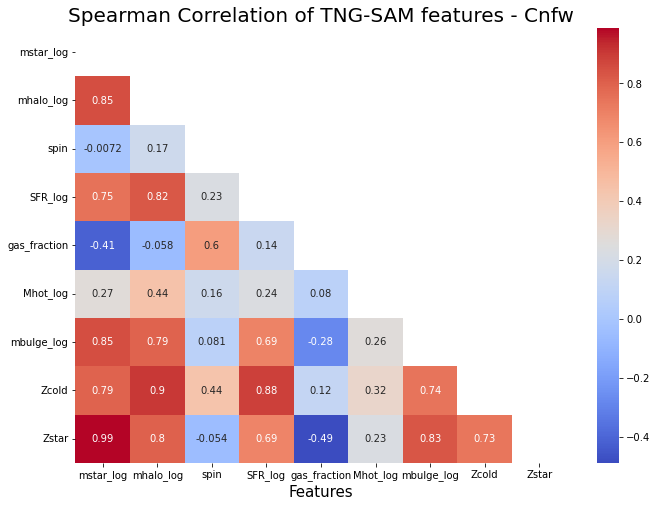

In [133]:
corr_el = X_el.corr('spearman')
plt.figure(figsize=(11,8))
matrix = np.triu(corr_el) # take upper correlation matrix
sns.heatmap(corr_el, cmap="coolwarm",annot=True, mask=matrix)
plt.title("Spearman Correlation of TNG-SAM features - Cnfw", fontsize = 20)
plt.xlabel("Features", fontsize = 15)
# plt.savefig('TNG-SAM_Spearman_correlation_matrix.jpeg', dpi=500)
plt.show()

In [134]:
X_train_el, X_test_el, y_train_el, y_test_el = train_test_split(X_el, y_el, test_size=0.33, random_state=42)

In [135]:
regr_el = RandomForestRegressor(max_depth=10, random_state=0)

In [136]:
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]
# number of features at every split
# max_features = ['auto', 'sqrt']


# create random grid
grid = {'bootstrap': [True],
               'max_depth': [5, 10, None],
#                'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
#                'min_samples_split': [2, 5, 10],
               'n_estimators': n_estimators}
# Random search of parameters
rfr_grid_el = GridSearchCV(estimator = regr_el, param_grid = grid, cv = 3, verbose=2, n_jobs = -1)
# Fit the model
rfr_grid_el.fit(X_train_el, y_train_el)
# print results
print(rfr_grid_el.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 50}


In [137]:
#  y_pred = rfr_grid.best_estimator_.predict(X_test)
y_pred_el = cross_val_predict(rfr_grid_el.best_estimator_, X_test_el, y_test_el, cv = KFold(n_splits=5, shuffle=True, random_state=10))

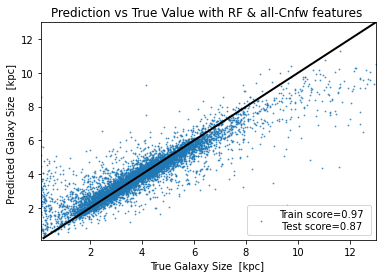

In [138]:
label = 'Train score={} \n Test score={}'.format(round(rfr_grid_el.best_estimator_.score(X_train_el, y_train_el), 2),round(rfr_grid_el.score(X_test_el, y_test_el), 2) )
plt.scatter(y_test, y_pred_el, s=3, marker='.', alpha=0.7, label=label)
plt.axis([0.1,13, 0.1,13])
plt.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value with RF & all-Cnfw features ')
plt.xlabel('True Galaxy Size  [kpc] ')
plt.ylabel(' Predicted Galaxy Size  [kpc]  ')
plt.legend(loc='lower right')
# plt.savefig('TNG-SAM_Prediction_vs_True_without_Cnfw.jpeg', dpi=500)
plt.show()

In [139]:
start_time = time.time()
importances_el = rfr_grid_el.best_estimator_.feature_importances_
std_el = np.std([tree.feature_importances_ for tree in rfr_grid_el.best_estimator_.estimators_], axis=0)
elapsed_time = time.time() - start_time

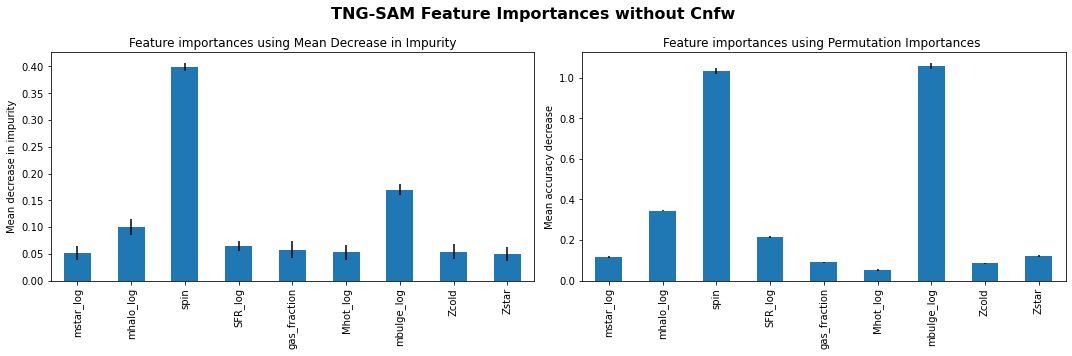

In [140]:
feature_names_el = X_test_el.columns

forest_importances_el = pd.Series(importances_el, index=feature_names_el)

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('TNG-SAM Feature Importances without Cnfw ', fontsize=16, fontweight='bold')

forest_importances_el.plot.bar(yerr=std_el, ax=ax1)
ax1.set_title("Feature importances using Mean Decrease in Impurity")
ax1.set_ylabel("Mean decrease in impurity")
# plt.savefig("Feature_Importances_MDI.jpeg", dpi=500)

### Feature Importances Permutation

start_time = time.time()
result_el = permutation_importance(
    rfr_grid_el.best_estimator_, X_test_el, y_test_el, n_repeats=10, random_state=0, n_jobs=-1
)
elapsed_time = time.time() - start_time
# print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances_el = pd.Series(result_el.importances_mean, index=feature_names_el)

forest_importances_el.plot.bar(yerr=result_el.importances_std, ax=ax2)
ax2.set_title("Feature importances using Permutation Importances ")
ax2.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
# plt.savefig("Feature_Importances_Permutation_without_Cnfw.jpeg", dpi=500)

plt.show()

### <font color='blue'> 2.b. Random Forest Model eliminating features

In [180]:
# X_el = df_central_log_pairplot.loc[:, ['spin', 'mbulge_log']]
# X_el = df_central_log_pairplot.loc[:, ['mstar_log', 'mhalo_log', 'spin', 'SFR_log', 'gas_fraction' , 'Mhot_log', 'mbulge_log',]]
X_el = df_central_log_pairplot.loc[:, ['mhalo_log', 'spin', 'Cnfw']]
# X_el = df_central_log_pairplot.loc[:, ['mstar_log', 'mhalo_log', 'spin', 'mbulge_log',]]
# X_el = df_central_log_pairplot.loc[:, ['mstar_log', 'spin', 'mbulge_log',]]
# X_el = df_central_log_pairplot.loc[:, [ 'spin', 'mbulge_log',]]

y_el = df_central_log_pairplot.loc[:,'half_radius']

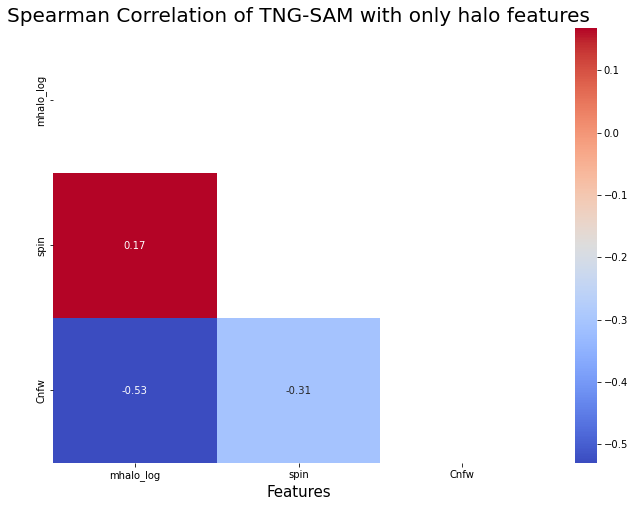

In [181]:
corr_el = X_el.corr('spearman')
plt.figure(figsize=(11,8))
matrix = np.triu(corr_el) # take upper correlation matrix
sns.heatmap(corr_el, cmap="coolwarm",annot=True, mask=matrix)
plt.title("Spearman Correlation of TNG-SAM with only halo features", fontsize = 20)
plt.xlabel("Features", fontsize = 15)
# plt.savefig('TNG-SAM_Spearman_correlation_matrix_halo_features.jpeg', dpi=500)
plt.show()

In [182]:
X_train_el, X_test_el, y_train_el, y_test_el = train_test_split(X_el, y_el, test_size=0.33, random_state=42)

regr_el = RandomForestRegressor(max_depth=10, random_state=0)

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]
# number of features at every split
# max_features = ['auto', 'sqrt']


# create random grid
grid = {'bootstrap': [True],
               'max_depth': [5, 10, None],
#                'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
#                'min_samples_split': [2, 5, 10],
               'n_estimators': n_estimators}
# Random search of parameters
rfr_grid_el = GridSearchCV(estimator = regr_el, param_grid = grid, cv = 3, verbose=2, n_jobs = -1)
# Fit the model
rfr_grid_el.fit(X_train_el, y_train_el)
# print results
print(rfr_grid_el.best_params_)

#  y_pred = rfr_grid.best_estimator_.predict(X_test)
y_pred_el = cross_val_predict(rfr_grid_el.best_estimator_, X_test_el, y_test_el, cv = KFold(n_splits=5, shuffle=True, random_state=10))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 50}


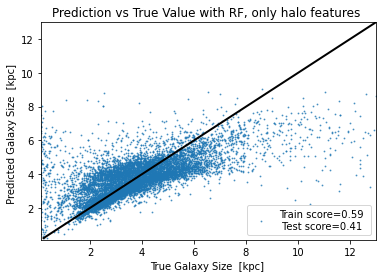

In [183]:
label = 'Train score={} \n Test score={}'.format(round(rfr_grid_el.best_estimator_.score(X_train_el, y_train_el), 2),round(rfr_grid_el.score(X_test_el, y_test_el), 2) )
plt.scatter(y_test, y_pred_el, s=3, marker='.', alpha=0.7, label=label)
plt.axis([0.1,13, 0.1,13])
plt.plot([0.2, 13], [0.2, 13], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value with RF, only halo features ')
plt.xlabel('True Galaxy Size  [kpc] ')
plt.ylabel(' Predicted Galaxy Size  [kpc]  ')
plt.legend(loc='lower right')
# plt.savefig('TNG-SAM_Prediction_vs_True_with_halo_features.jpeg', dpi=500)
plt.show()

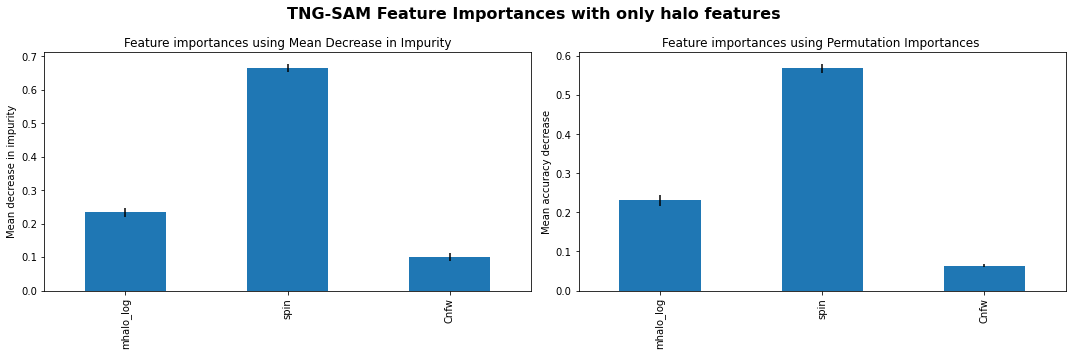

[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, n_estimators=30; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=30; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, n_estimators=30; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, n_estimators=10; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, n_estimators=30; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, n_estimators=30; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=30; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_sample

In [184]:
start_time = time.time()
importances_el = rfr_grid_el.best_estimator_.feature_importances_
std_el = np.std([tree.feature_importances_ for tree in rfr_grid_el.best_estimator_.estimators_], axis=0)
elapsed_time = time.time() - start_time

feature_names_el = X_test_el.columns

forest_importances_el = pd.Series(importances_el, index=feature_names_el)

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('TNG-SAM Feature Importances with only halo features ', fontsize=16, fontweight='bold')

forest_importances_el.plot.bar(yerr=std_el, ax=ax1)
ax1.set_title("Feature importances using Mean Decrease in Impurity")
ax1.set_ylabel("Mean decrease in impurity")
# plt.savefig("Feature_Importances_MDI.jpeg", dpi=500)

### Feature Importances Permutation

start_time = time.time()
result_el = permutation_importance(
    rfr_grid_el.best_estimator_, X_test_el, y_test_el, n_repeats=10, random_state=0, n_jobs=-1
)
elapsed_time = time.time() - start_time
# print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances_el = pd.Series(result_el.importances_mean, index=feature_names_el)

forest_importances_el.plot.bar(yerr=result_el.importances_std, ax=ax2)
ax2.set_title("Feature importances using Permutation Importances ")
ax2.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
# plt.savefig("TNG-SAM_Feature_Importances_Permutation_halo_features.jpeg", dpi=500)

plt.show()

In [ ]:
fig,[ax1, ax5, ax6 ]=plt.subplots(nrows=1,ncols=3,sharey=True, figsize=(15,5))
# fig.suptitle('SIMBA Central Galaxies Size Prediction', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

label = 'Train score={} \n Test score={}'.format(round(reg_stellar_mass.score(X_train_stellar_mass, y_train), 2),round(reg_stellar_mass.score(X_test_stellar_mass, y_test), 2) )
im1 = ax1.scatter(y_test, y_pred_reg_stellar, s=3, marker='.', alpha=0.7, label=label)
ax1.axis([0.1,1.3, 0.1,1.3])
ax1.plot([0.2, 1.2], [0.2, 1.2], color = 'black', linewidth = 2)
ax1.set_title('Linear Regression Model \n with only Stellar Mass')
ax1.set_xlabel('True $ log_{10} $ Galaxy Size  [kpc]')
ax1.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax1.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(reg.score(X_train, y_train), 2),round(reg.score(X_test, y_test), 2) )
im5 = ax5.scatter(y_test, y_pred_reg, s=3, marker='.', alpha=0.7, label=label)
ax5.axis([0.1,1.3, 0.1,1.3])
ax5.plot([0.2, 1.2], [0.2, 1.2], color = 'black', linewidth = 2)
ax5.set_title('Linear Regression Model \n with all the features')
ax5.set_xlabel('True $ log_{10} $ Galaxy Size  [kpc]')
# ax5.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax5.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(rfr_grid.best_estimator_.score(X_train,y_train), 2),round(rfr_grid.best_estimator_.score(X_test,y_test), 2) )
im6 = ax6.scatter(y_test, y_pred, s=3, marker='.', alpha=0.7, label=label)
ax6.axis([0.1,1.3, 0.1,1.3])
ax6.plot([0.2, 1.2], [0.2, 1.2], color = 'black', linewidth = 2)
ax6.set_title('Random Forest Regressor Model \n with all the features')
ax6.set_xlabel('True $ log_{10} $ Galaxy Size  [kpc]')
# ax6.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax6.legend(loc='lower right', shadow=True)
    
# grid = plt.GridSpec(3, 2)
# create_subtitle(fig, grid[0, ::], 'Linear Regression with only Stellar Mass as a feature')
# create_subtitle(fig, grid[1, ::], 'Linear Regression with only Halo Mass as a feature')
# create_subtitle(fig, grid[2, ::], 'Linear Regression vs Random Forest Regressor with all features')

# fig.subplots_adjust(hspace=0.0, wspace=0.0)
fig.tight_layout()
# plt.savefig("SIMBA_LR_vs_RF_size_prediction.jpeg", dpi=500)
plt.show()